## This is the Modeling part of the Bigdata Class Project - Individual City Analysis - Pittburgh

* pyspark
* pyspark dataframe
* pyspark sql

In [1]:
sc

In [26]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString, VectorIndexer, Word2Vec
from pyspark.ml import Pipeline

from geopandas import GeoDataFrame
import matplotlib.pylab as plt

%matplotlib inline

#pyspark.ml.feature.Word2Vec?

### Load Pre-Processed Shapefile for Pittburgh

In [467]:
#shape_path = "Pittsburgh_Tracts/Pittsburgh_tracts.shp"
shape_path = "pitt tract/BussinessStars.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.TRACT
ct_shape_spark = sqlContext.createDataFrame(ct_shape)

In [468]:
ct_shape.head()

,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_5_17,AGE_65_UP,AGE_UNDER5,AMERI_ES,ASIAN,...,VACANT,WHITE,business_i,geometry,latitude,longitude,rate,stars,sum_weekda,sum_weeken
TRACT,,,,,,,,,,,,,,,,,,,,,
010300,2899,366,130,114,143,80,148,42,12,147,...,253,3075,xO09rJXkqonSRzUzcwjoFQ,POINT (-79.99128849999994 40.43730530000005),40.437305,-79.991288,0.183544,4.0,158,29
010300,2899,366,130,114,143,80,148,42,12,147,...,253,3075,uCVlfxoph6iFgztZC72Mxw,POINT (-79.98528539999995 40.43613680000004),40.436137,-79.985285,0.447368,3.5,38,17
010300,2899,366,130,114,143,80,148,42,12,147,...,253,3075,rDgiBah58fc6AfVD58m2mw,POINT (-79.99201099999993 40.43870140000007),40.438701,-79.992011,0.444444,3.5,27,12
010300,2899,366,130,114,143,80,148,42,12,147,...,253,3075,5Qa1bKl5BeXOC_6kZV7nBw,POINT (-79.98878489999998 40.43846700000006),40.438467,-79.988785,0.208333,3.0,24,5
010300,2899,366,130,114,143,80,148,42,12,147,...,253,3075,kiVnUirURYI91t9YY3nddQ,POINT (-79.98797799999994 40.43845300000004),40.438453,-79.987978,0.321839,3.5,87,28


In [469]:
ct_shape_spark.show(3)

+---------+---------+---------+---------+---------+--------+---------+----------+--------+-----+----------+---------+-----+---------+--------+-------+---------+-----------+------+-------+--------+----------+----------+----------+---------+-----+---------+----------+-------+---------+---------+---------+---------+--------+----------+-----+---------+----------+----------+----------+-------+-------+----------+----+----------+--------+----------------+---------------+------+------+-----+--------------------+--------------------+----------+-----------+--------+-----+----------+----------+
|AGE_18_21|AGE_22_29|AGE_30_39|AGE_40_49|AGE_50_64|AGE_5_17|AGE_65_UP|AGE_UNDER5|AMERI_ES|ASIAN|AVE_FAM_SZ|AVE_HH_SZ|BLACK|CNTY_FIPS|FAMILIES|FEMALES|FHH_CHILD|       FIPS|Field1|HAWN_PI|HISPANIC|HOUSEHOLDS|HSEHLD_1_F|HSEHLD_1_M|HSE_UNITS|MALES|MARHH_CHD|MARHH_NO_C|MED_AGE|MED_AGE_F|MED_AGE_M|MHH_CHILD|MULT_RACE|OBJECTID|OBJECTID_1|OTHER|OWNER_OCC|ObjectID_2|POP00_SQMI|POP07_SQMI|POP2000|POP2007|RENTER_OCC

In [470]:
ct_shape_spark.printSchema()

root
 |-- AGE_18_21: long (nullable = true)
 |-- AGE_22_29: long (nullable = true)
 |-- AGE_30_39: long (nullable = true)
 |-- AGE_40_49: long (nullable = true)
 |-- AGE_50_64: long (nullable = true)
 |-- AGE_5_17: long (nullable = true)
 |-- AGE_65_UP: long (nullable = true)
 |-- AGE_UNDER5: long (nullable = true)
 |-- AMERI_ES: long (nullable = true)
 |-- ASIAN: long (nullable = true)
 |-- AVE_FAM_SZ: double (nullable = true)
 |-- AVE_HH_SZ: double (nullable = true)
 |-- BLACK: long (nullable = true)
 |-- CNTY_FIPS: string (nullable = true)
 |-- FAMILIES: long (nullable = true)
 |-- FEMALES: long (nullable = true)
 |-- FHH_CHILD: long (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- Field1: long (nullable = true)
 |-- HAWN_PI: long (nullable = true)
 |-- HISPANIC: long (nullable = true)
 |-- HOUSEHOLDS: long (nullable = true)
 |-- HSEHLD_1_F: long (nullable = true)
 |-- HSEHLD_1_M: long (nullable = true)
 |-- HSE_UNITS: long (nullable = true)
 |-- MALES: long (nullable = tr

In [213]:
##ct_shape_spark.select("geometry").show()
type(ct_shape)

geopandas.geodataframe.GeoDataFrame

## Plot just to see the business locations

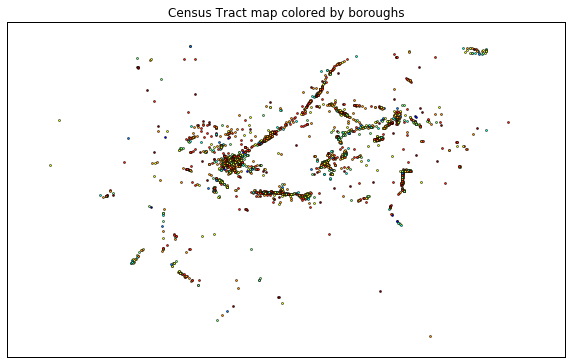

In [471]:
f, ax = plt.subplots(figsize=(10,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column ="stars",alpha=1, linewidth=0.5, ax=ax)
plt.title("Census Tract map colored by boroughs")


In [472]:
df_train = ct_shape_spark.select(ct_shape_spark["business_i"],ct_shape_spark['stars'].cast('float'), \
                       ct_shape_spark['sum_weekda'].cast('int'), ct_shape_spark['sum_weeken'].cast('int'),\
                                ct_shape_spark["TRACT"].cast('int'), ct_shape_spark["rate"].cast('float'))

In [473]:
df_train.show(5)

+--------------------+-----+----------+----------+-----+--------+
|          business_i|stars|sum_weekda|sum_weeken|TRACT|    rate|
+--------------------+-----+----------+----------+-----+--------+
|xO09rJXkqonSRzUzc...|  4.0|       158|        29|10300|0.183544|
|uCVlfxoph6iFgztZC...|  3.5|        38|        17|10300|0.447368|
|rDgiBah58fc6AfVD5...|  3.5|        27|        12|10300|0.444444|
|5Qa1bKl5BeXOC_6kZ...|  3.0|        24|         5|10300|0.208333|
|kiVnUirURYI91t9YY...|  3.5|        87|        28|10300|0.321839|
+--------------------+-----+----------+----------+-----+--------+
only showing top 5 rows



## Exploratory Analysis  : 
* Kmeans Clustering,  Using Pyspark

In [474]:
Kmeans = KMeans(k = 3, seed = 1) # call kmeans

# assembler the four digit features 
assembler = VectorAssembler(inputCols=['stars','sum_weekda','sum_weeken', 'rate'], outputCol="features") 

# combine use pipeline
pipeline = Pipeline(stages=[assembler, Kmeans])



In [475]:
data = df_train
# split the data 
trainTest_kmean = data.randomSplit([0.5, 0.5])
trainingData_kmean = trainTest_kmean[0]
testData_kmean = trainTest_kmean[1]

In [476]:
# Train the model on the training data
model = pipeline.fit(data)

# Run the model also on the training data (for evaluation purposes)
training = model.transform(data)

In [477]:
# # Run the model on the testing data for predictions
predictions = model.transform(testData_kmean)
predictions.show()

+--------------------+-----+----------+----------+-----+---------+--------------------+----------+
|          business_i|stars|sum_weekda|sum_weeken|TRACT|     rate|            features|prediction|
+--------------------+-----+----------+----------+-----+---------+--------------------+----------+
|-23t2qOQWj8Kqp-Ij...|  3.0|        27|        10|20100|  0.37037|[3.0,27.0,10.0,0....|         0|
|-4bNlx03GsXzgkHZw...|  3.0|       214|       131|20100|  0.61215|[3.0,214.0,131.0,...|         2|
|-QMukwCbH8djqluG5...|  3.5|       138|        17|20100| 0.123188|[3.5,138.0,17.0,0...|         0|
|-UqxkoufE3WGTnLZV...|  4.0|       129|        50|20100| 0.387597|[4.0,129.0,50.0,0...|         0|
|-nfzEVOVvmDSFbxvB...|  2.5|        26|        10|20100| 0.384615|[2.5,26.0,10.0,0....|         0|
|-yB1gsnF4gROLFWzZ...|  4.5|        13|         2|20100| 0.153846|[4.5,13.0,2.0,0.1...|         0|
|04P3hZHQY4Wq7atYI...|  3.5|         4|         0|20100|      0.0|   [3.5,4.0,0.0,0.0]|         0|
|05FkTuKNf

## Join the labels with shapefile

## Turn the dataframe into SQL table : Rename columns and Select the features

In [478]:
df_pandas = predictions.toPandas()
df_pandas.to_csv("with_labels.csv")

sqlContext.registerDataFrameAsTable(predictions, "predictions_table")

label_sqltable= sqlContext.sql("SELECT business_i,\
                      prediction AS cluster_label from predictions_table")

label_sqltable.show(5)

+--------------------+-------------+
|          business_i|cluster_label|
+--------------------+-------------+
|-23t2qOQWj8Kqp-Ij...|            0|
|-4bNlx03GsXzgkHZw...|            2|
|-QMukwCbH8djqluG5...|            0|
|-UqxkoufE3WGTnLZV...|            0|
|-nfzEVOVvmDSFbxvB...|            0|
+--------------------+-------------+
only showing top 5 rows



In [479]:
#merged_labels = df2.join(ct_shape_spark, on = "business_i", how = 'inner')
label = label_sqltable.toPandas()
label.head()

,business_i,cluster_label
0,-23t2qOQWj8Kqp-Ijm1BQA,0
1,-4bNlx03GsXzgkHZwTrMaw,2
2,-QMukwCbH8djqluG5Vulbw,0
3,-UqxkoufE3WGTnLZV9em3w,0
4,-nfzEVOVvmDSFbxvBsllGQ,0


## Visualization:

In [480]:
df_merged = ct_shape.merge(label, on ="business_i", how = "inner")

df_merged.head()

,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_5_17,AGE_65_UP,AGE_UNDER5,AMERI_ES,ASIAN,...,WHITE,business_i,geometry,latitude,longitude,rate,stars,sum_weekda,sum_weeken,cluster_label
0,2899,366,130,114,143,80,148,42,12,147,...,3075,rDgiBah58fc6AfVD58m2mw,POINT (-79.99201099999993 40.43870140000007),40.438701,-79.992011,0.444444,3.5,27,12,0
1,2899,366,130,114,143,80,148,42,12,147,...,3075,5Qa1bKl5BeXOC_6kZV7nBw,POINT (-79.98878489999998 40.43846700000006),40.438467,-79.988785,0.208333,3.0,24,5,0
2,2899,366,130,114,143,80,148,42,12,147,...,3075,kiVnUirURYI91t9YY3nddQ,POINT (-79.98797799999994 40.43845300000004),40.438453,-79.987978,0.321839,3.5,87,28,0
3,2899,366,130,114,143,80,148,42,12,147,...,3075,iTsMcekQkdMfYTl9ZKwxww,POINT (-79.98389949999995 40.43737870000007),40.437379,-79.983900,0.000000,5.0,3,0,0
4,2899,366,130,114,143,80,148,42,12,147,...,3075,CLZwf-pAbUXRKiWhnPo2Qg,POINT (-79.99126667899998 40.43867487200004),40.438675,-79.991267,0.488372,3.0,43,21,0


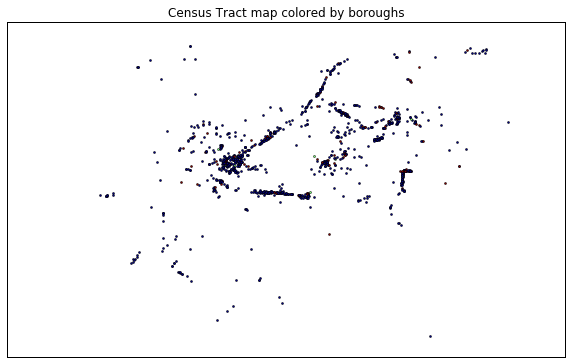

In [481]:
f, ax = plt.subplots(figsize=(10,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_merged.plot(column ="cluster_label",alpha=1, linewidth=10, ax=ax)

plt.title("Census Tract map colored by boroughs")



In [482]:
df_pandas = predictions.toPandas()
df_pandas.to_csv("with_labels.csv")

### take look of the cluster result:

In [277]:
predictions.filter(predictions.prediction == 2).take(5)

[Row(business_i=u'0bDp9GJBQ4K4ZTzvewLoVA', stars=3.5, sum_weekda=307, sum_weeken=281, TRACT=20300, rate=0.9153090119361877, features=DenseVector([3.5, 307.0, 281.0, 0.9153]), prediction=2),
 Row(business_i=u'4D2FmqwuQ_OXypQkQqQZcw', stars=3.5, sum_weekda=193, sum_weeken=64, TRACT=20100, rate=0.33160600066185, features=DenseVector([3.5, 193.0, 64.0, 0.3316]), prediction=2),
 Row(business_i=u'5reb2cEaziuyHOpnbh1XtA', stars=3.5, sum_weekda=165, sum_weeken=70, TRACT=20100, rate=0.4242419898509979, features=DenseVector([3.5, 165.0, 70.0, 0.4242]), prediction=2),
 Row(business_i=u'7ijQJV72aBrEoJCtTBCHxw', stars=3.5, sum_weekda=357, sum_weeken=95, TRACT=20100, rate=0.2661060094833374, features=DenseVector([3.5, 357.0, 95.0, 0.2661]), prediction=2),
 Row(business_i=u'7xNe2WZAQUGMp1_CxGVKnQ', stars=3.0, sum_weekda=206, sum_weeken=75, TRACT=20100, rate=0.36407798528671265, features=DenseVector([3.0, 206.0, 75.0, 0.3641]), prediction=2)]

In [278]:
predictions.filter(predictions.prediction == 1).take(5)

[Row(business_i=u'Hjo5B_MgC5iK-Onf7EJyhA', stars=4.0, sum_weekda=802, sum_weeken=423, TRACT=20100, rate=0.5274310111999512, features=DenseVector([4.0, 802.0, 423.0, 0.5274]), prediction=1),
 Row(business_i=u'UXlGymo9AduQcq-Q-H16og', stars=4.0, sum_weekda=631, sum_weeken=370, TRACT=20100, rate=0.5863710045814514, features=DenseVector([4.0, 631.0, 370.0, 0.5864]), prediction=1),
 Row(business_i=u'cjD2yGRhT5yaSj_KP55Ptw', stars=4.0, sum_weekda=542, sum_weeken=369, TRACT=20300, rate=0.6808120012283325, features=DenseVector([4.0, 542.0, 369.0, 0.6808]), prediction=1),
 Row(business_i=u'rcCGdKxMPJk4lCzZZ1i_bA', stars=4.5, sum_weekda=813, sum_weeken=416, TRACT=20300, rate=0.5116850137710571, features=DenseVector([4.5, 813.0, 416.0, 0.5117]), prediction=1),
 Row(business_i=u'BfvzYmIkVgceomExPsChqQ', stars=4.5, sum_weekda=865, sum_weeken=78, TRACT=40300, rate=0.0901734009385109, features=DenseVector([4.5, 865.0, 78.0, 0.0902]), prediction=1)]

In [279]:
predictions.filter(predictions.prediction == 0).take(5)

[Row(business_i=u'-KQ283hJkBO12u8XOrlCcQ', stars=3.0, sum_weekda=116, sum_weeken=59, TRACT=20100, rate=0.5086209774017334, features=DenseVector([3.0, 116.0, 59.0, 0.5086]), prediction=0),
 Row(business_i=u'-QMukwCbH8djqluG5Vulbw', stars=3.5, sum_weekda=138, sum_weeken=17, TRACT=20100, rate=0.12318799644708633, features=DenseVector([3.5, 138.0, 17.0, 0.1232]), prediction=0),
 Row(business_i=u'-TSFapUMwdyyxoi2egkOhw', stars=2.5, sum_weekda=7, sum_weeken=2, TRACT=20100, rate=0.2857140004634857, features=DenseVector([2.5, 7.0, 2.0, 0.2857]), prediction=0),
 Row(business_i=u'-UqxkoufE3WGTnLZV9em3w', stars=4.0, sum_weekda=129, sum_weeken=50, TRACT=20100, rate=0.387596994638443, features=DenseVector([4.0, 129.0, 50.0, 0.3876]), prediction=0),
 Row(business_i=u'-j4cyxQhg3uikKll8GspBw', stars=4.5, sum_weekda=3, sum_weeken=11, TRACT=20300, rate=3.666670083999634, features=DenseVector([4.5, 3.0, 11.0, 3.6667]), prediction=0)]

In [282]:
#predictions.select("prediction").

predictions.groupBy('prediction').mean("stars", "sum_weekda", "sum_weeken").show()

+----------+------------------+------------------+------------------+
|prediction|        avg(stars)|   avg(sum_weekda)|   avg(sum_weeken)|
+----------+------------------+------------------+------------------+
|         1| 3.888888888888889| 685.6666666666666|410.22222222222223|
|         2|              3.85| 231.8153846153846|131.43076923076924|
|         0|3.7341188524590163|28.826844262295083|14.645491803278688|
+----------+------------------+------------------+------------------+



## As a result, we would like to discover more for the label 1 restaurants and neighborhood

-----

## Decision Tree

In [383]:
sqltable_dt = sqlContext.sql("SELECT business_i,\
                      prediction AS cluster_label, stars, sum_weekda,sum_weeken,rate, tract\
                      from predictions_table")

sqltable_dt

DataFrame[business_i: string, cluster_label: int, stars: float, sum_weekda: int, sum_weeken: int, rate: float, tract: int]

In [393]:
assembler = VectorAssembler(inputCols=['stars','sum_weeken','sum_weekda',"rate", "tract"], outputCol="features")

indexer = StringIndexer(inputCol="stars", outputCol="DT_labels").fit(sqltable_dt)

# Specify model
dt = DecisionTreeClassifier(labelCol = "cluster_label", featuresCol="features")
pipeline = Pipeline(stages=[assembler, indexer, dt])


In [406]:
trainTest = sqltable_dt.randomSplit([0.5, 0.5])
trainingData = trainTest[0]
testData = trainTest[1]
testData.show(3)

+--------------------+-------------+-----+----------+----------+--------+-----+
|          business_i|cluster_label|stars|sum_weekda|sum_weeken|    rate|tract|
+--------------------+-------------+-----+----------+----------+--------+-----+
|-QMukwCbH8djqluG5...|            0|  3.5|       138|        17|0.123188|20100|
|-UqxkoufE3WGTnLZV...|            0|  4.0|       129|        50|0.387597|20100|
|-j4cyxQhg3uikKll8...|            0|  4.5|         3|        11| 3.66667|20300|
+--------------------+-------------+-----+----------+----------+--------+-----+
only showing top 3 rows



In [395]:
# Train the model on the training data
model = pipeline.fit(testData)

# Run the model also on the training data (for evaluation purposes)
training = model.transform(trainingData)



In [405]:
# # Run the model on the testing data for predictions
predictions = model.transform(testData)
predictions.show(5)

+--------------------+-------------+-----+----------+----------+--------+-----+--------------------+---------+---------------+-------------+----------+
|          business_i|cluster_label|stars|sum_weekda|sum_weeken|    rate|tract|            features|DT_labels|  rawPrediction|  probability|prediction|
+--------------------+-------------+-----+----------+----------+--------+-----+--------------------+---------+---------------+-------------+----------+
|-UqxkoufE3WGTnLZV...|            0|  4.0|       129|        50|0.387597|20100|[4.0,50.0,129.0,0...|      0.0|[482.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|-j4cyxQhg3uikKll8...|            0|  4.5|         3|        11| 3.66667|20300|[4.5,11.0,3.0,3.6...|      2.0|[482.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|0ORPehdGZci1Z_BTK...|            0|  3.0|        62|        48|0.774194|20100|[3.0,48.0,62.0,0....|      3.0|[482.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|0bDp9GJBQ4K4ZTzve...|            2|  3.5|       307|       281|0.915309|20300|[3.5,281.

In [397]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cluster_label", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(training)
print "Test Error = %g" % (1.0 - accuracy)


Test Error = 0.0307414


## Using Decision Tree model to train on the 'stars','sum_weeken','sum_weekda',"rate", "tract" features to predict the labels of the cluster. The accuracy rate is 97%
---

In [91]:
# from pyspark.ml.regression import LinearRegression

# assembler = VectorAssembler(inputCols=['cool','funny','useful'], outputCol="features")

# indexer = StringIndexer(inputCol="stars", outputCol="labels").fit(fil_new)
# # Specify model
# dt = LinearRegression(labelCol = "labels", featuresCol="features")
# pipeline = Pipeline(stages=[assembler, indexer, dt])

# # Train the model on the training data
# model = pipeline.fit(testData)

# # Run the model also on the training data (for evaluation purposes)
# training = model.transform(trainingData)


In [398]:
# # # Run the model on the testing data for predictions
# predictions = model.transform(testData)
# predictions.select('features', 'labels', 'prediction').show(10)

## We would like to see the data separately, just study  label 1 restaurants

In [435]:
df_merged_spark = sqlContext.createDataFrame(df_merged)
df_merged_1 = df_merged_spark.filter(df_merged_spark.cluster_label ==1)


## Aggregate by stars and tracts of label 1 restaurants

In [458]:
df_merged_1.groupBy('TRACT', "stars").count().orderBy("count",ascending=False).show()
count = df_merged_1.groupBy('TRACT', "stars").count().orderBy("count",ascending=False)

+------+-----+-----+
| TRACT|stars|count|
+------+-----+-----+
|220500|  4.5|    2|
|020100|  4.0|    2|
|141300|  4.0|    1|
|060300|  3.5|    1|
|020300|  4.0|    1|
|070900|  3.0|    1|
|090200|  3.5|    1|
|070500|  4.0|    1|
|190300|  4.5|    1|
|170200|  4.5|    1|
|040400|  3.5|    1|
|111500|  3.5|    1|
|070500|  3.5|    1|
|040300|  4.5|    1|
|160900|  2.5|    1|
|020300|  4.5|    1|
+------+-----+-----+



In [464]:
count.filter(count.stars > 3.5).select("TRACT").groupBy('TRACT').count().show()

+------+-----+
| TRACT|count|
+------+-----+
|040300|    1|
|220500|    1|
|190300|    1|
|141300|    1|
|020100|    1|
|020300|    2|
|070500|    1|
|170200|    1|
+------+-----+



## 403 -  Squirrel Hill North
## 1903 - Mount Washington
## 1413 - Squirrel Hill South
##  201 - Central Business District 
## 0203 - Strip District
## 1702 - Southside Flats
## 0705 - Shadyside


## Look at the overall data with all the labels

In [441]:
df_merged_spark.groupBy('TRACT').count().orderBy('count',ascending=False).show()

+------+-----+
| TRACT|count|
+------+-----+
|020100|  193|
|020300|   75|
|170200|   73|
|160900|   55|
|070300|   49|
|040500|   47|
|140800|   35|
|111500|   35|
|192100|   30|
|070500|   30|
|040400|   22|
|141300|   22|
|090100|   21|
|220500|   21|
|080400|   20|
|080200|   17|
|060300|   17|
|101100|   16|
|090300|   15|
|090200|   15|
+------+-----+
only showing top 20 rows



In [465]:
count_1 = df_merged_spark.groupBy('TRACT', "stars").count().orderBy('count',ascending=False)
count_1.filter(count_1.stars > 3.5).select("TRACT").show(15)

+------+
| TRACT|
+------+
|020100|
|020100|
|170200|
|020300|
|020300|
|160900|
|170200|
|140800|
|070300|
|040500|
|070500|
|070300|
|160900|
|192100|
|040500|
+------+
only showing top 15 rows



## 0201 - Central Business District 
## 1702, 1609 - Southside Flats


## 0203 - Strip District

Strip District
After spending a couple of decades focused on soccer practices, dance classes and dioramas, empty nesters may want to get back to urban living once the kids move out. There are few better spots than the resurgent Strip District, where new lofts and condominiums are going up amidst restaurants and markets.
Walk Score: 70

## 1609 - Southside Flats
## 0703, 0705 - Shadyside
## 1408 - Squirrel Hill South
## 0405 - Central Oakland
## 0902 - Central Lawrenceville
Central Lawrenceville Nicknamed the “Brooklyn of Pittsburgh,” Lawrenceville is home to an eclectic mix of retail outlets (within a block on Butler Street: a tea shop, a bike shop, a guitar store, a florist and a zombie-themed store) and hordes of bars ranging from divey to upscale. The area has become popular rapidly (and highly sought by investors and house flippers), but rowhouses and single-family homes still can be had at reasonable prices.
Walk Score: 73
